# Variability of PBMCs in head & neck cancer samples


---

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
import tifffile
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannot import add_stat_annotation
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from skimage.io import imread
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ranksums, ttest_ind
from statannotations.Annotator import Annotator
from collections import Counter
from sklearn.model_selection import cross_val_score

import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300

import sys
import cv2 as cv

sys.path.append("../../..")
from src.utils.notebooks.eda import *
from src.utils.notebooks.figure3 import *

seed = 1234
random.seed(1234)
np.random.seed(1234)

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def plot_rep_prot_markers_dist(
    data, markers, marker_labels, quantiles=None, cut=2, plot_type="violin"
):
    for i in range(len(markers)):
        fig, ax = plot_marker_distribution(
            data,
            figsize=[6, 4],
            marker=markers[i],
            label_col="replicate",
            box_pairs=[
                ("1", "2"),
            ],
            stat_annot="star",
            quantiles=quantiles,
            cut=cut,
            plot_type=plot_type,
        )
        ax.set_xlabel("condition")
        ax.set_ylabel(marker_labels[i])
        plt.show()
        plt.close()

<IPython.core.display.Javascript object>

---

## 1. Read in data

#### Replicate 1

In [3]:
rep1_root_data_dir = "../../../data/headneck/proteins/timepoint_2"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"

<IPython.core.display.Javascript object>

In [4]:
rep1_data = read_in_protein_dataset(
    data_dir=rep1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)
rep1_data["id"] = rep1_data["sample"] + rep1_data["timepoint"]
rep1_data["replicate"] = "1"
rep1_data["file_name"] = np.array(list(rep1_data.index))

Load data: 100%|██████████| 8/8 [00:00<00:00, 23.92it/s]


<IPython.core.display.Javascript object>

#### Replicate 2

In [6]:
rep2_root_data_dir = "../../../data/headneck/marker/timepoint_2"

rep2_data = read_in_protein_dataset(
    data_dir=rep2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)
rep2_data["id"] = rep2_data["sample"] + rep2_data["timepoint"]
rep2_data["replicate"] = "2"
rep2_data["file_name"] = np.array(list(rep2_data.index))

Load data: 100%|██████████| 8/8 [00:00<00:00, 24.51it/s]


<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Before we analyze the data, we will first preprocess it.

To this end, we first remove features with missing values and samples with missing features.

In [7]:
rep1_data = preprocess_data(rep1_data, remove_constant_features=False)
rep2_data = preprocess_data(rep2_data, remove_constant_features=False)

Nuclei that did not pass the quality check: 301/4470. Remaining: 4169.
Removed 12 constant or features with missing values. Remaining: 291.
Removed additional 6 features. Remaining: 285.
Nuclei that did not pass the quality check: 215/4005. Remaining: 3790.
Removed 12 constant or features with missing values. Remaining: 290.
Removed additional 6 features. Remaining: 284.


<IPython.core.display.Javascript object>

___

#### Subsampling

We first subsample the data set such that for each condition (control vs. cancer) we have the same number of nuclei in the data set. Additionally, we ensure that for the cancer population we have approximately equal number of nuclei from each biological sample.

In [8]:
sampled_rep1_data = get_stratified_data(
    rep1_data, id_column="id", cond_column="sample", seed=1234
)
sampled_rep2_data = get_stratified_data(
    rep2_data, id_column="id", cond_column="sample", seed=1234
)

<IPython.core.display.Javascript object>

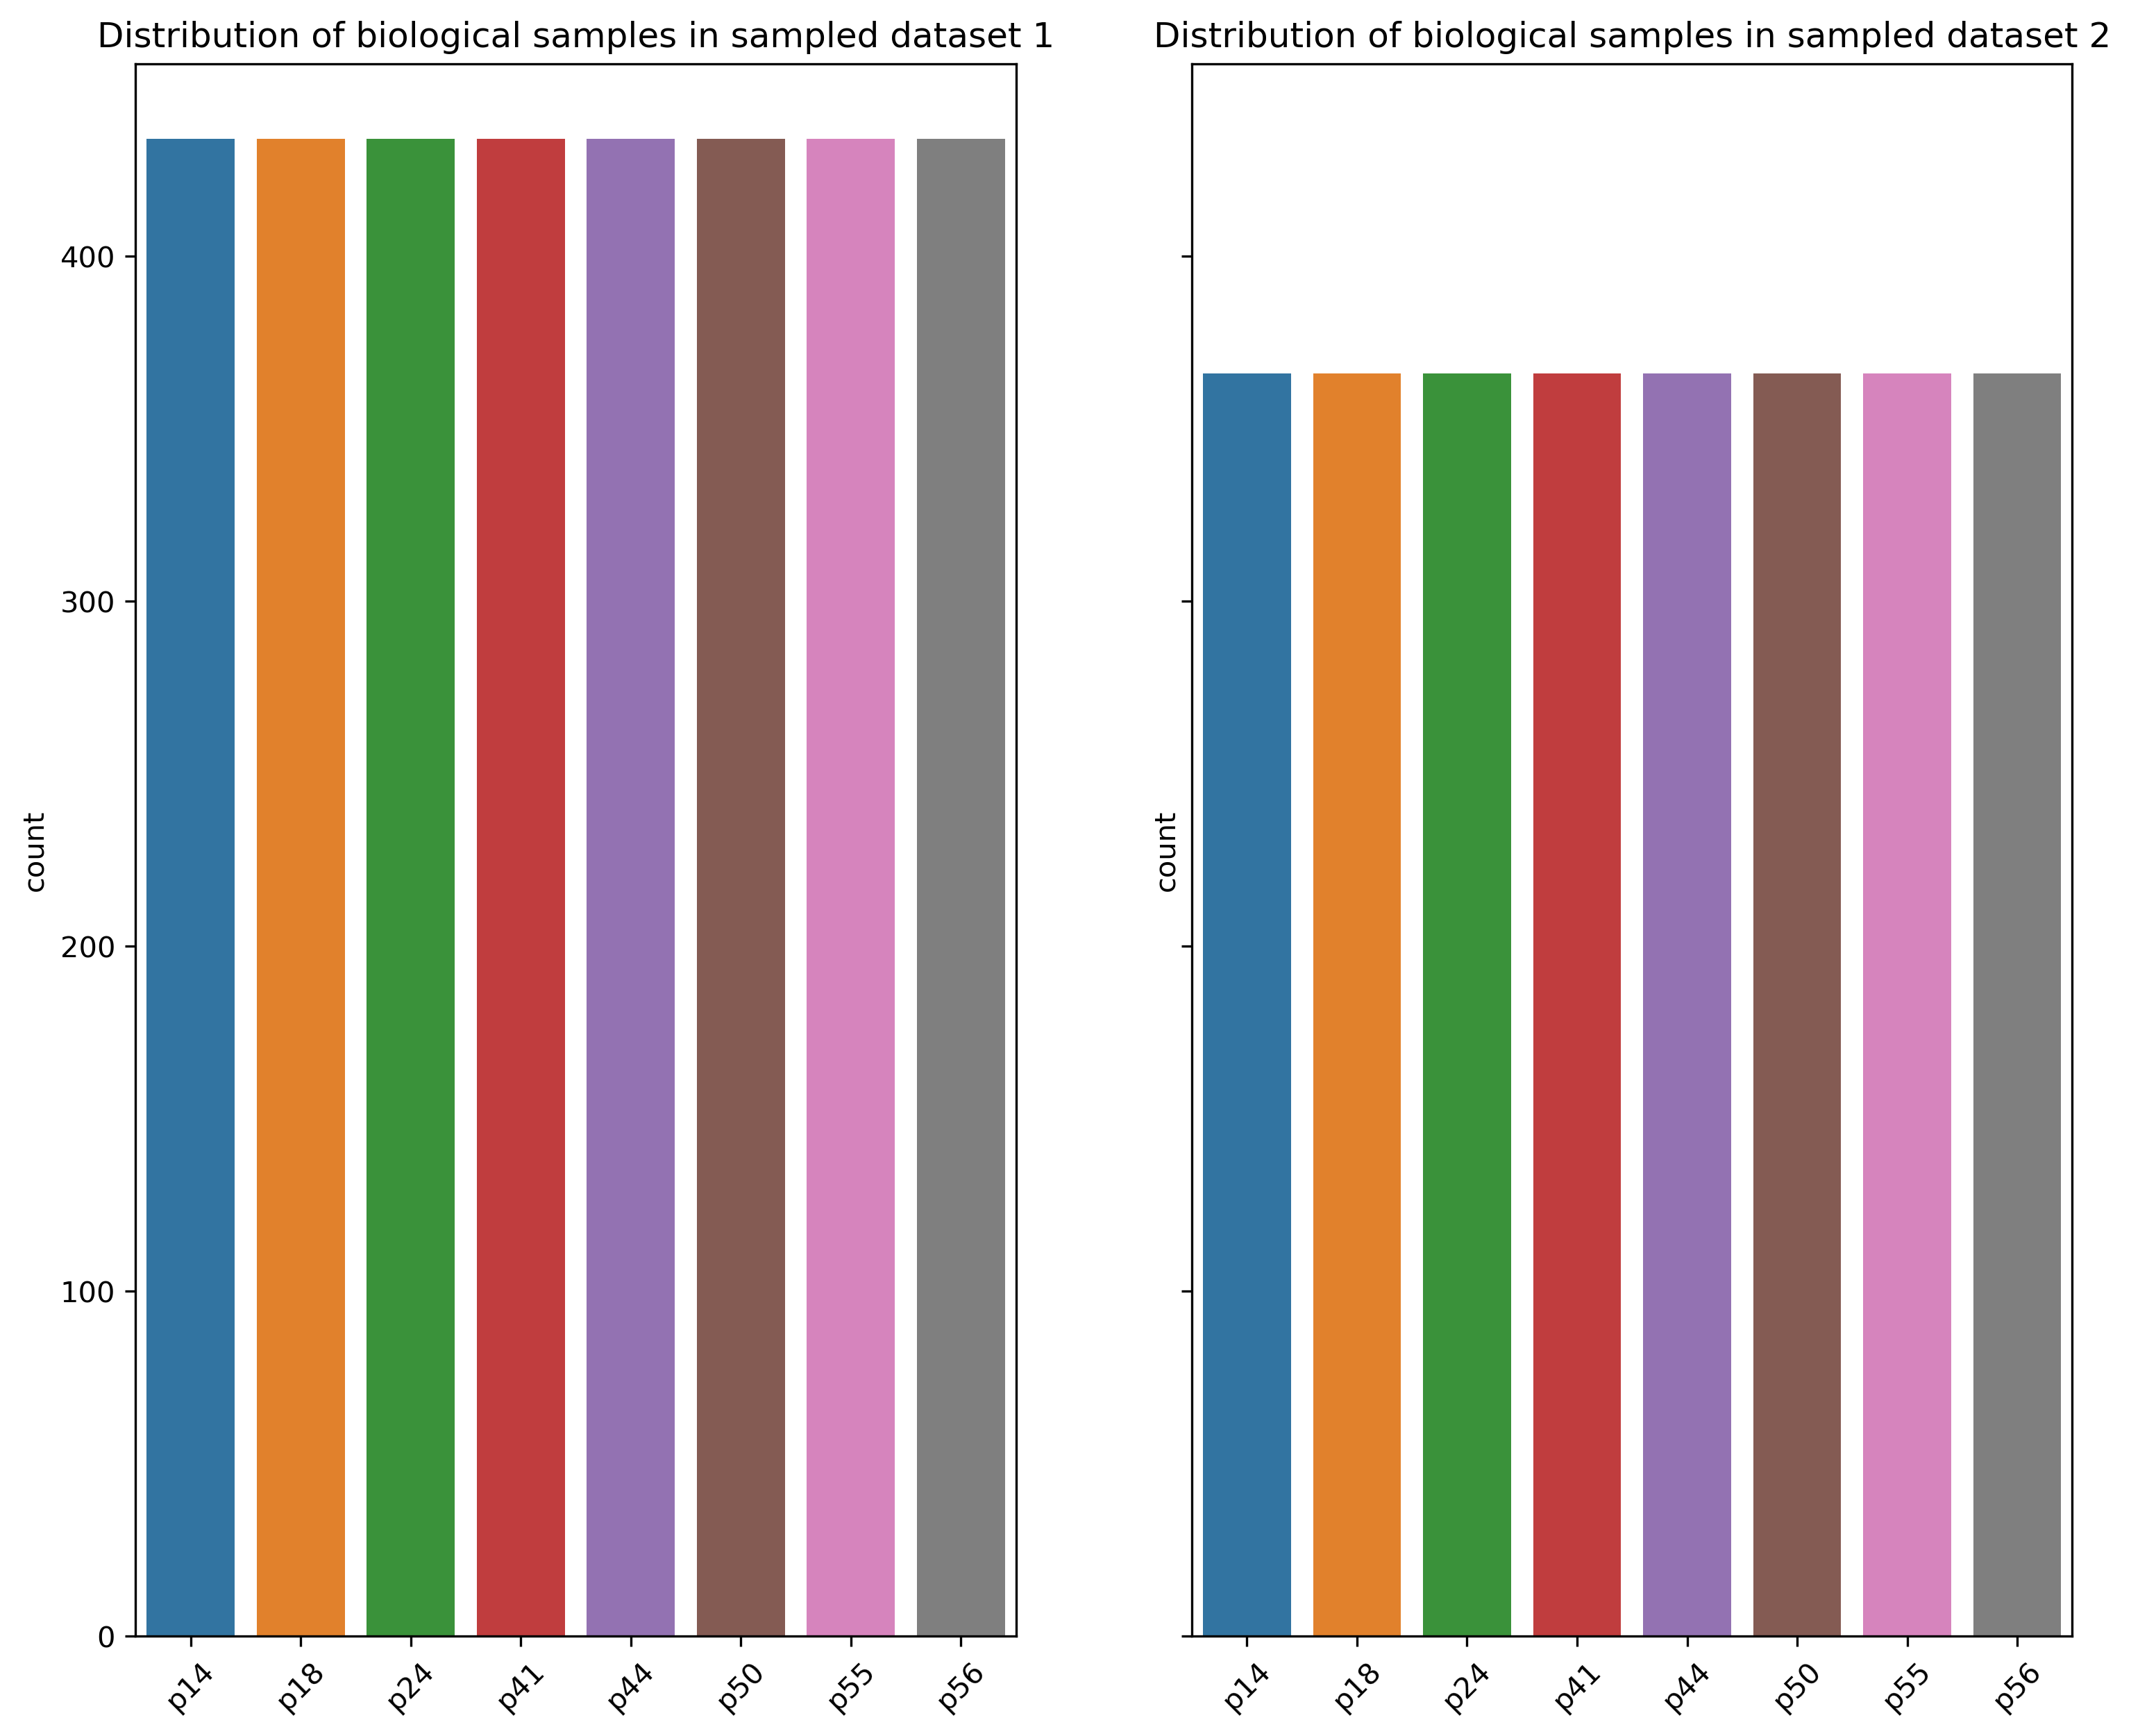

<IPython.core.display.Javascript object>

In [9]:
rep_labels = ["1", "2"]

fig, ax = plt.subplots(figsize=[12, 10], ncols=2, nrows=1, sharey=True)
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=sampled_rep1_data,
    ax=ax[0],
    order=np.unique(sampled_rep1_data.loc[:, "sample"]),
)
ax[1] = sns.countplot(
    x="sample",
    data=sampled_rep2_data,
    ax=ax[1],
    order=np.unique(sampled_rep2_data.loc[:, "sample"]),
)
for i in range(len(ax)):
    ax[i].set_xlabel("")
    ax[i].set_title(
        "Distribution of biological samples in sampled dataset {}".format(rep_labels[i])
    )
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(45)
plt.show()
plt.close()

----

#### Sample and feature selection

We now filter out constant features and nuclei with missing features. We will do that for both replicates individually. However, we will also combine the two replicates to provide a joint analysis.

In [10]:
data = preprocess_data(
    sampled_rep1_data.append(sampled_rep2_data),
    remove_constant_features=True,
)

Nuclei that did not pass the quality check: 0/6400. Remaining: 6400.
Removed 125 constant or features with missing values. Remaining: 220.
Removed additional 0 features. Remaining: 220.


<IPython.core.display.Javascript object>

---

#### Data preparation

After sampling the data, we will now prepare the data for the consecutive analysis, i.e. extracting only chrometric features and corresponding metadata information.

In [11]:
chrometric_data = get_chrometric_data(data, proteins=[], exclude_dna_int=True)
sample_labels = data.loc[:, "sample"]
rep_labels = data.replicate

<IPython.core.display.Javascript object>

Finally, we remove highly correlated features (Pearson $\rho > 0.8$) from the chrometric features.

In [12]:
chrometric_data = remove_correlated_features(chrometric_data, threshold=0.8)

Removed 146/193 features with a Pearson correlation above 0.8. Remaining: 47


<IPython.core.display.Javascript object>

---

## 3. Analyses


### 3a. Visualization of the replicate samples

In [13]:
image_file_path = "preprocessed/full_pipeline/segmentation/nuclei_images"
sampled_rep1_images = get_random_images(
    sampled_rep1_data,
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
    file_name_col="file_name",
)
sampled_rep2_images = get_random_images(
    sampled_rep2_data,
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
    file_name_col="file_name",
)


<IPython.core.display.Javascript object>

### Replicate 1

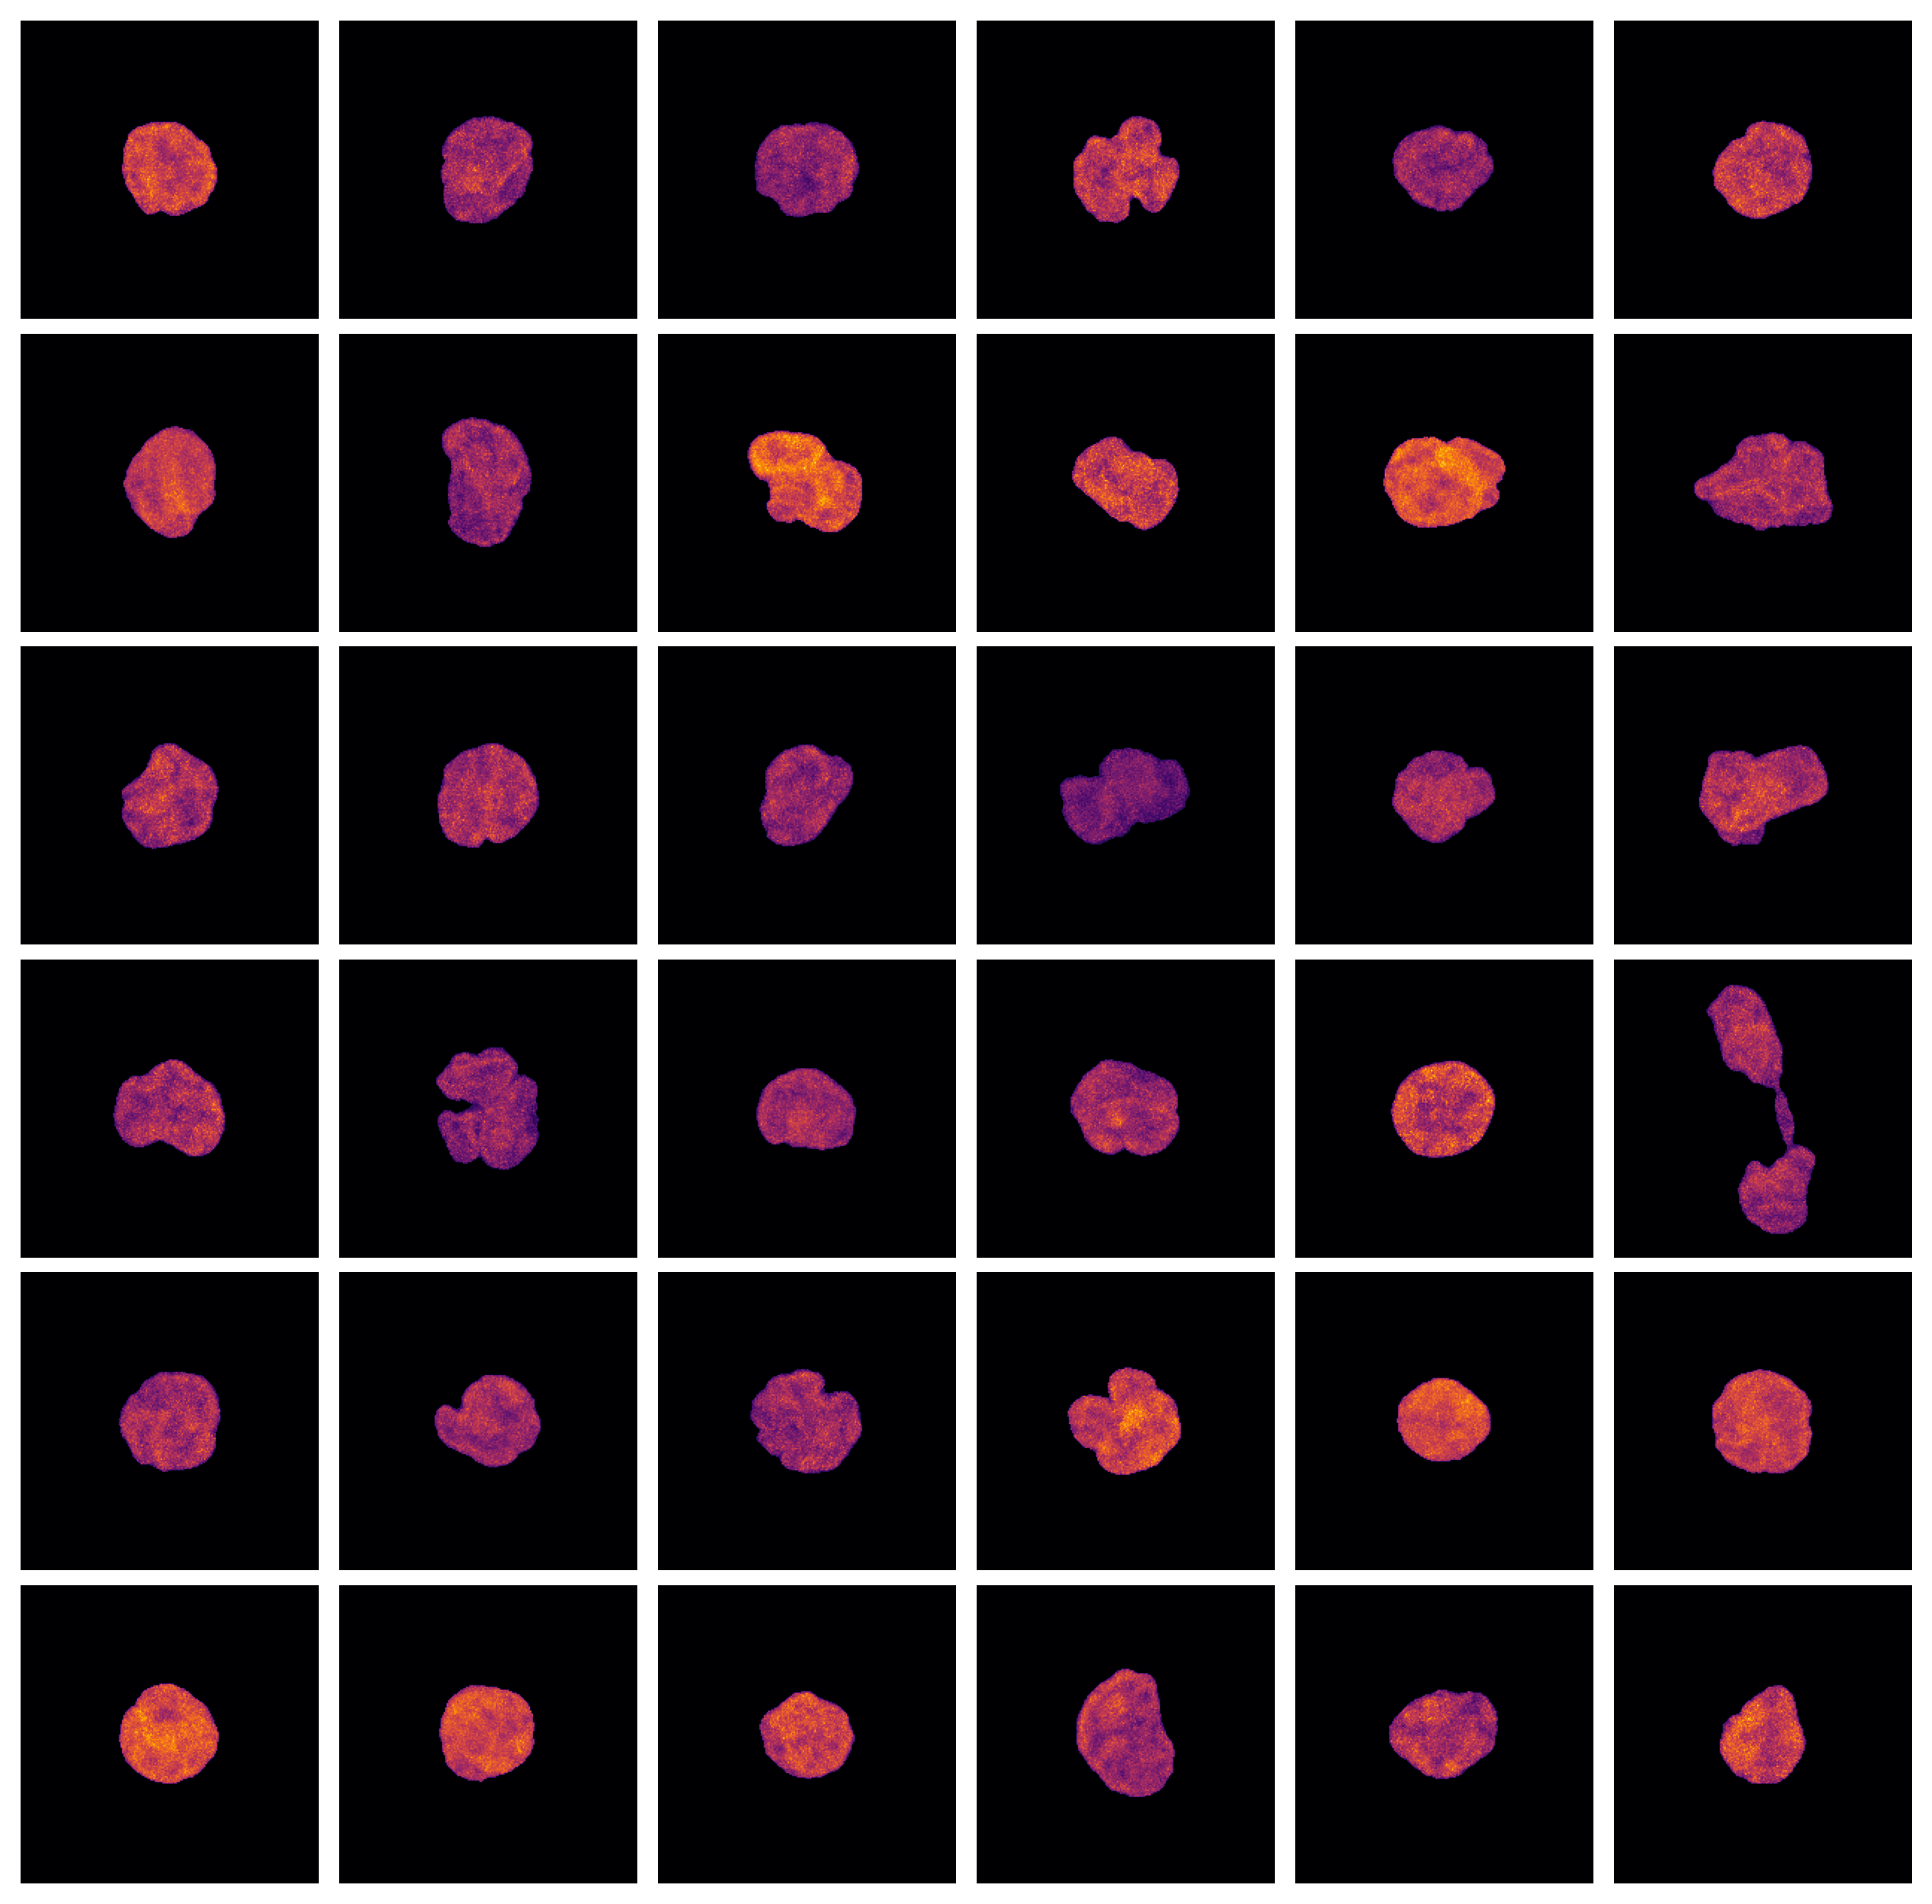

<IPython.core.display.Javascript object>

In [16]:
fig_rep1, ax_rep1 = plot_montage(
    sampled_rep1_images, pad_size=200, mask_nuclei=True, cmap="inferno"
)

### Replicate 2

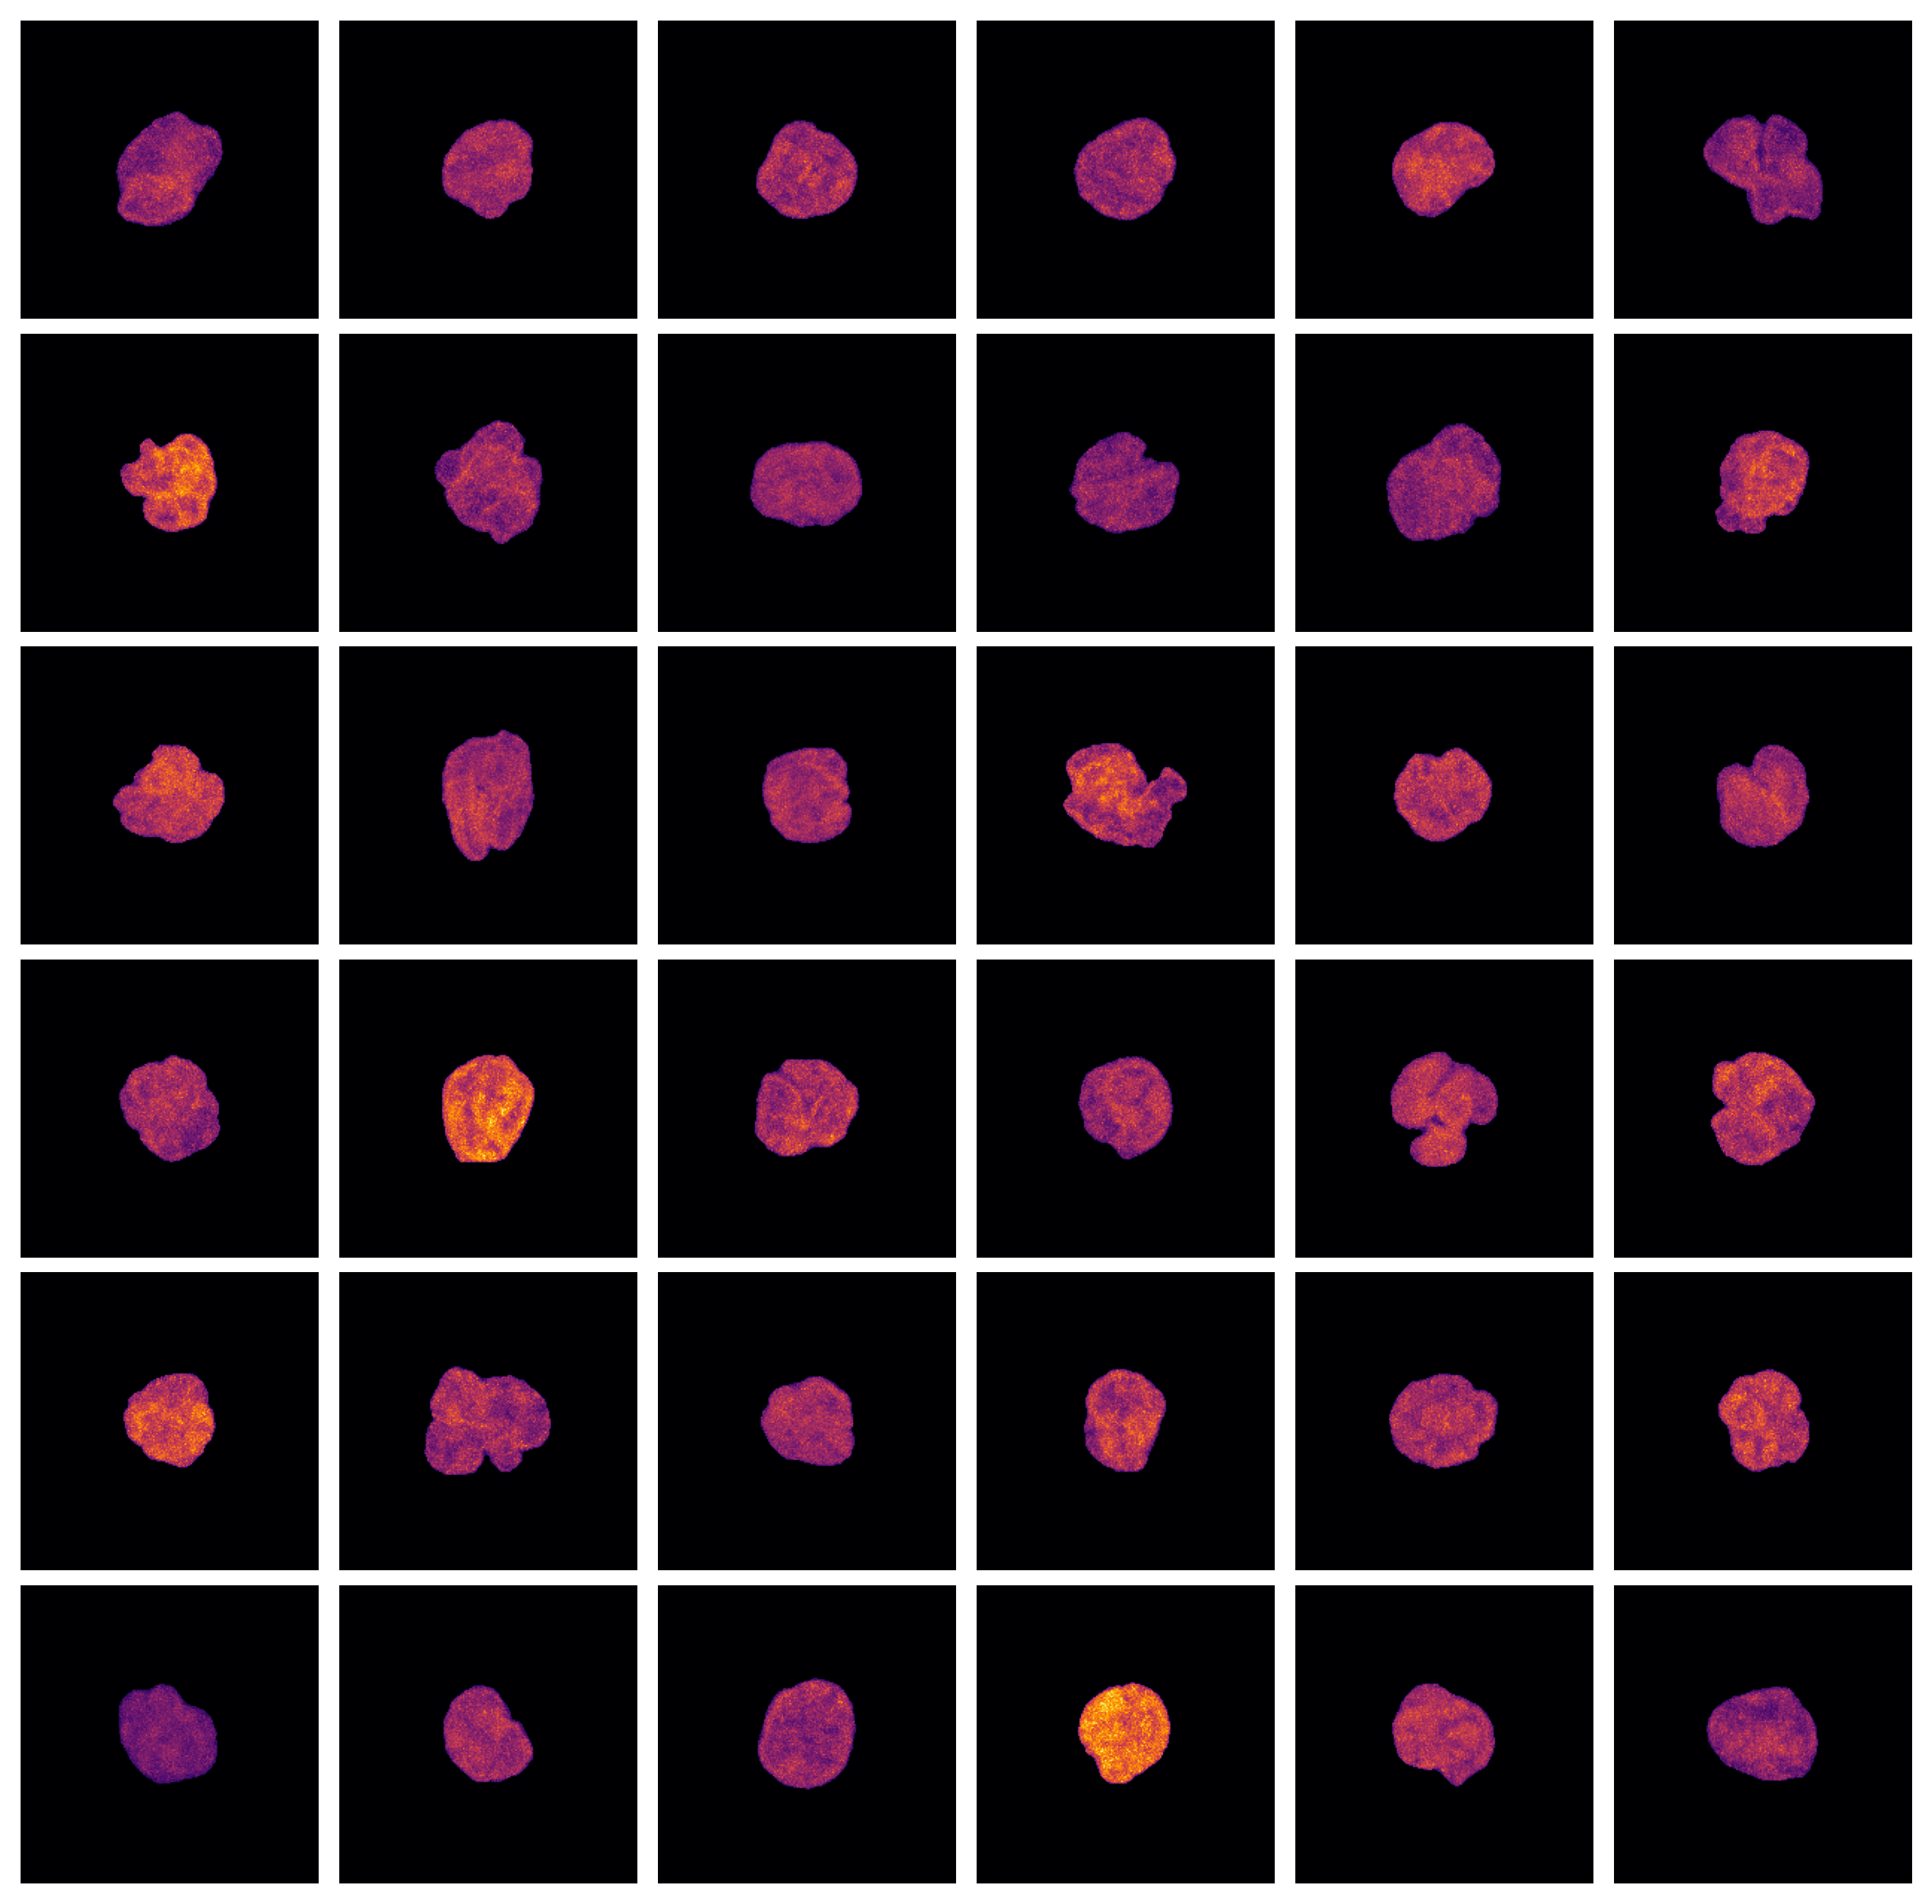

<IPython.core.display.Javascript object>

In [17]:
fig_rep2, ax_rep2 = plot_montage(
    sampled_rep2_images, pad_size=200, mask_nuclei=True, cmap="inferno"
)

---

### 3b. Replicate specificity

In [18]:
chrometric_embs = get_tsne_embs(chrometric_data)
chrometric_embs["sample"] = sample_labels
chrometric_embs["replicate"] = rep_labels

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

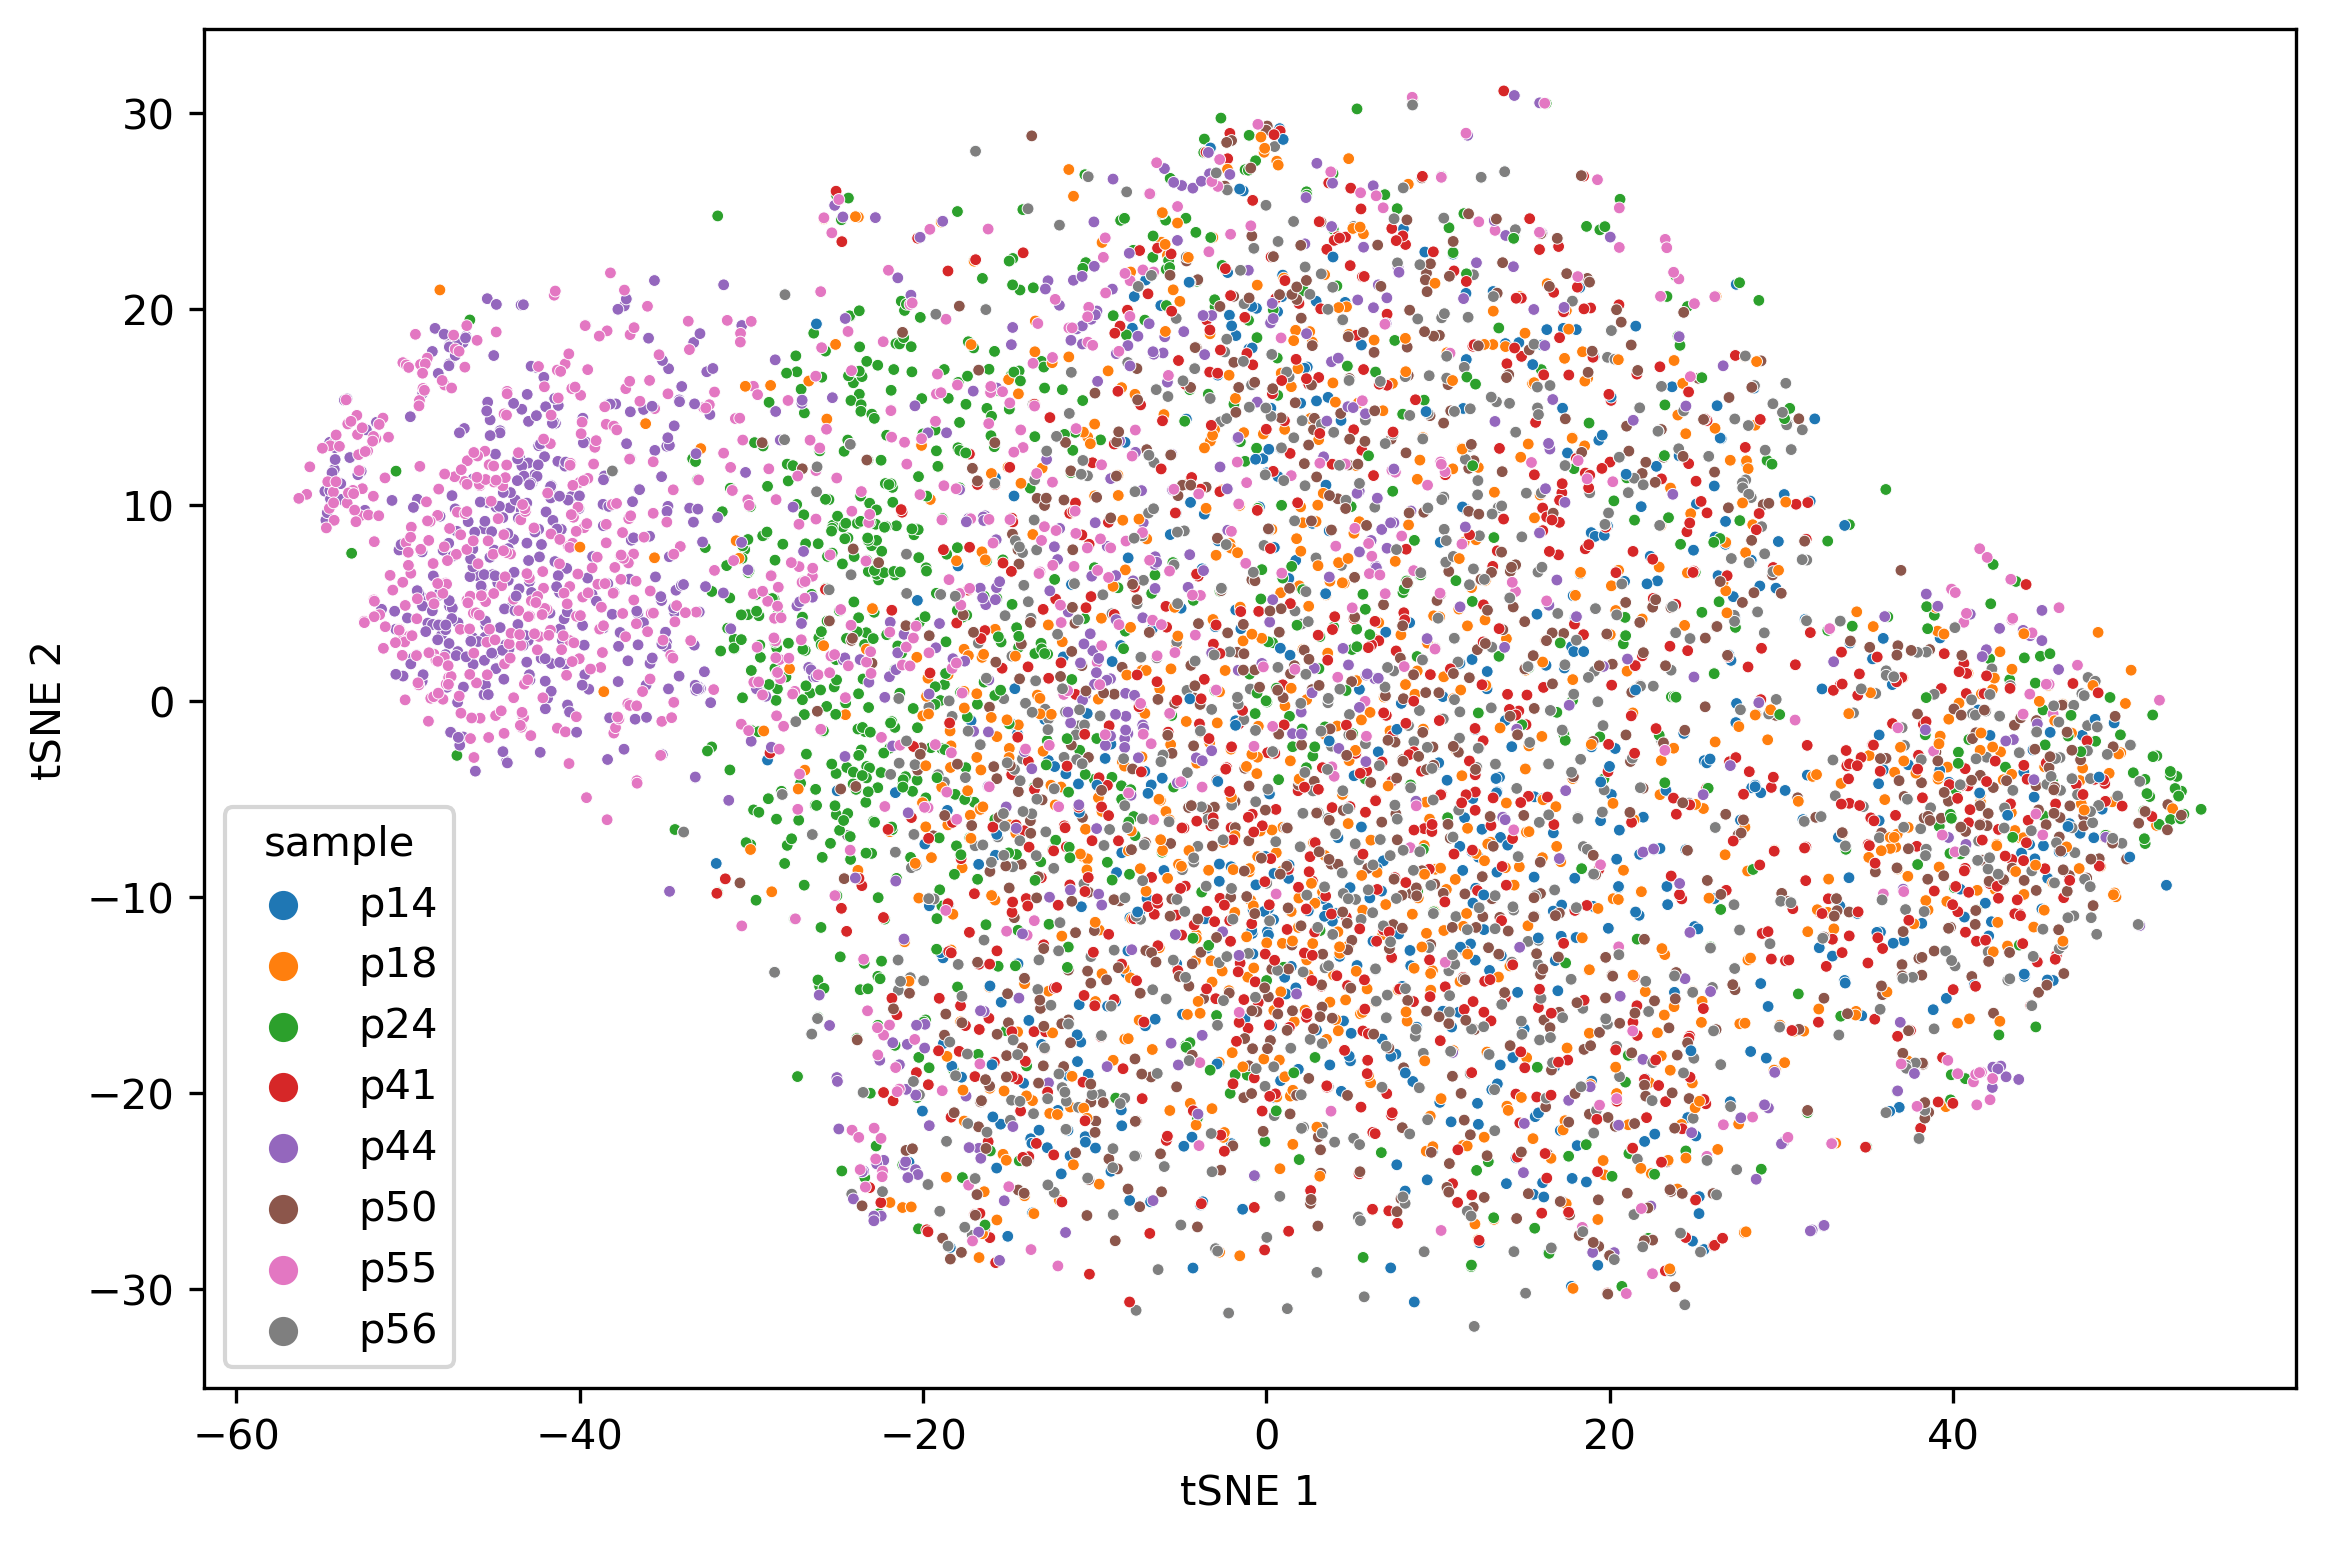

<IPython.core.display.Javascript object>

In [19]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=chrometric_embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="sample",
    ax=ax,
    s=8,
    marker="o",
)
plt.show()

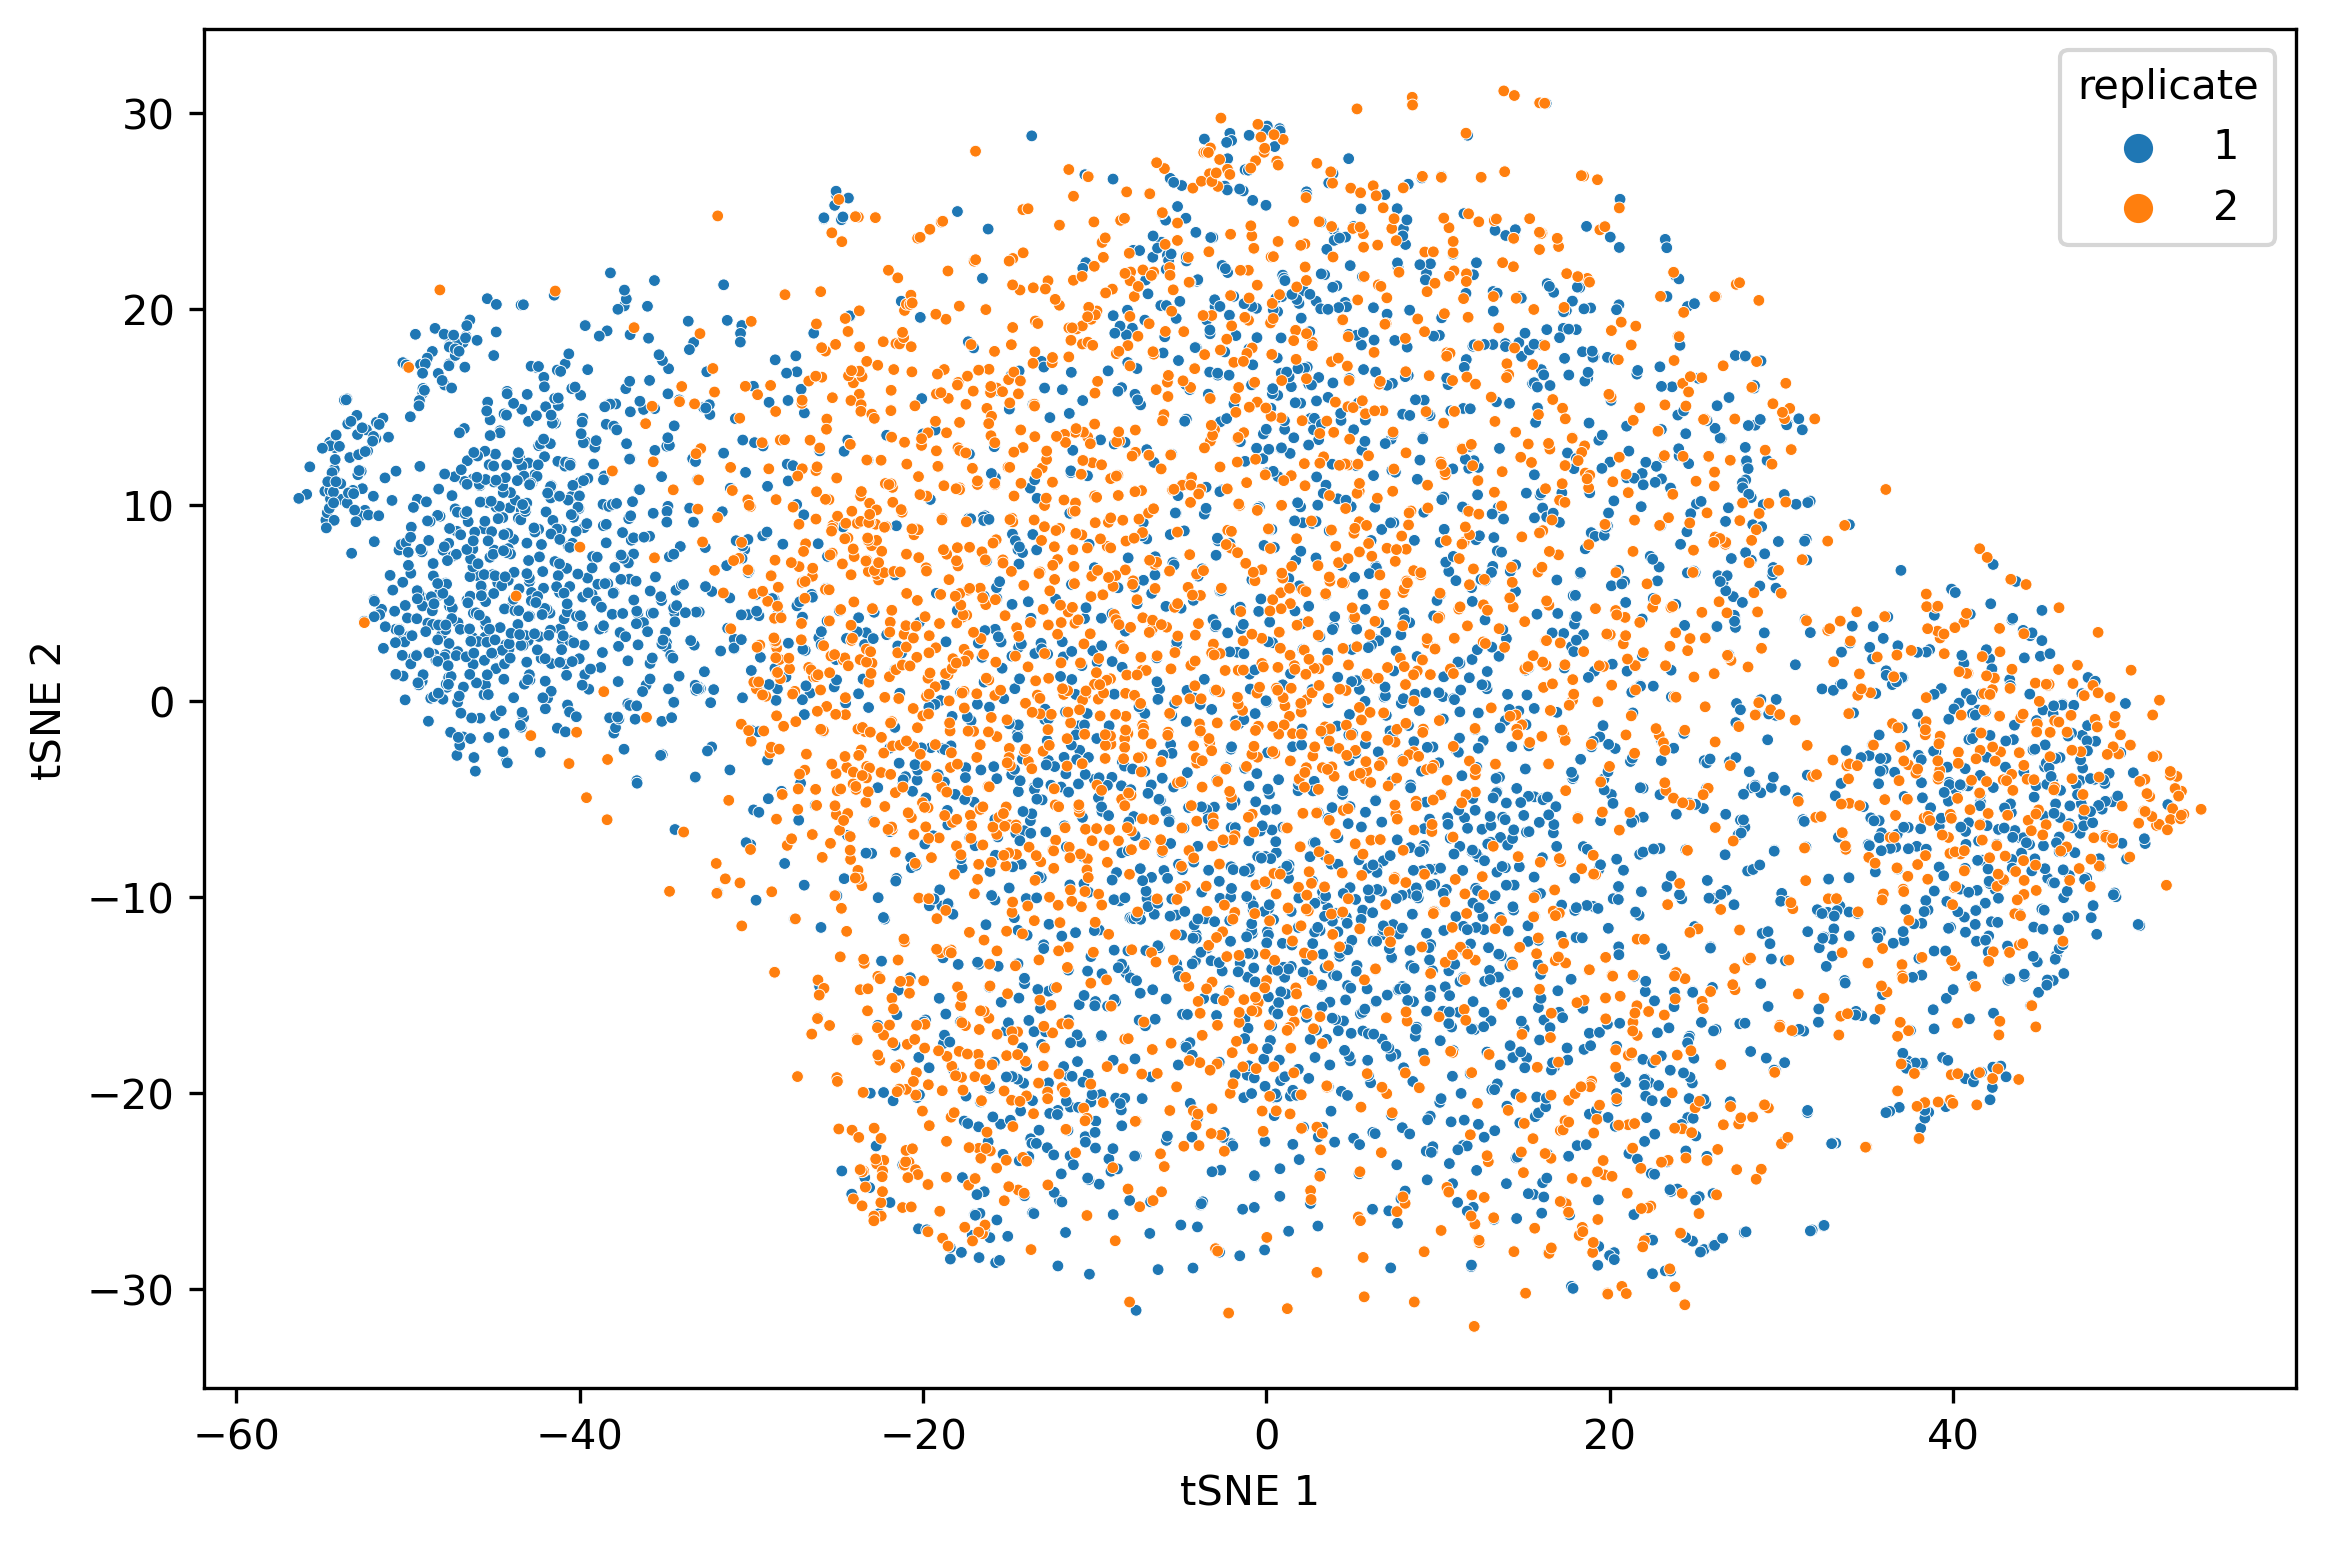

<IPython.core.display.Javascript object>

In [20]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=chrometric_embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="replicate",
    ax=ax,
    s=8,
    marker="o",
    palette="tab10",
)
plt.show()

---

In [21]:
rfc = RandomForestClassifier(
    n_estimators=100, n_jobs=10, random_state=seed, class_weight="balanced"
)

<IPython.core.display.Javascript object>

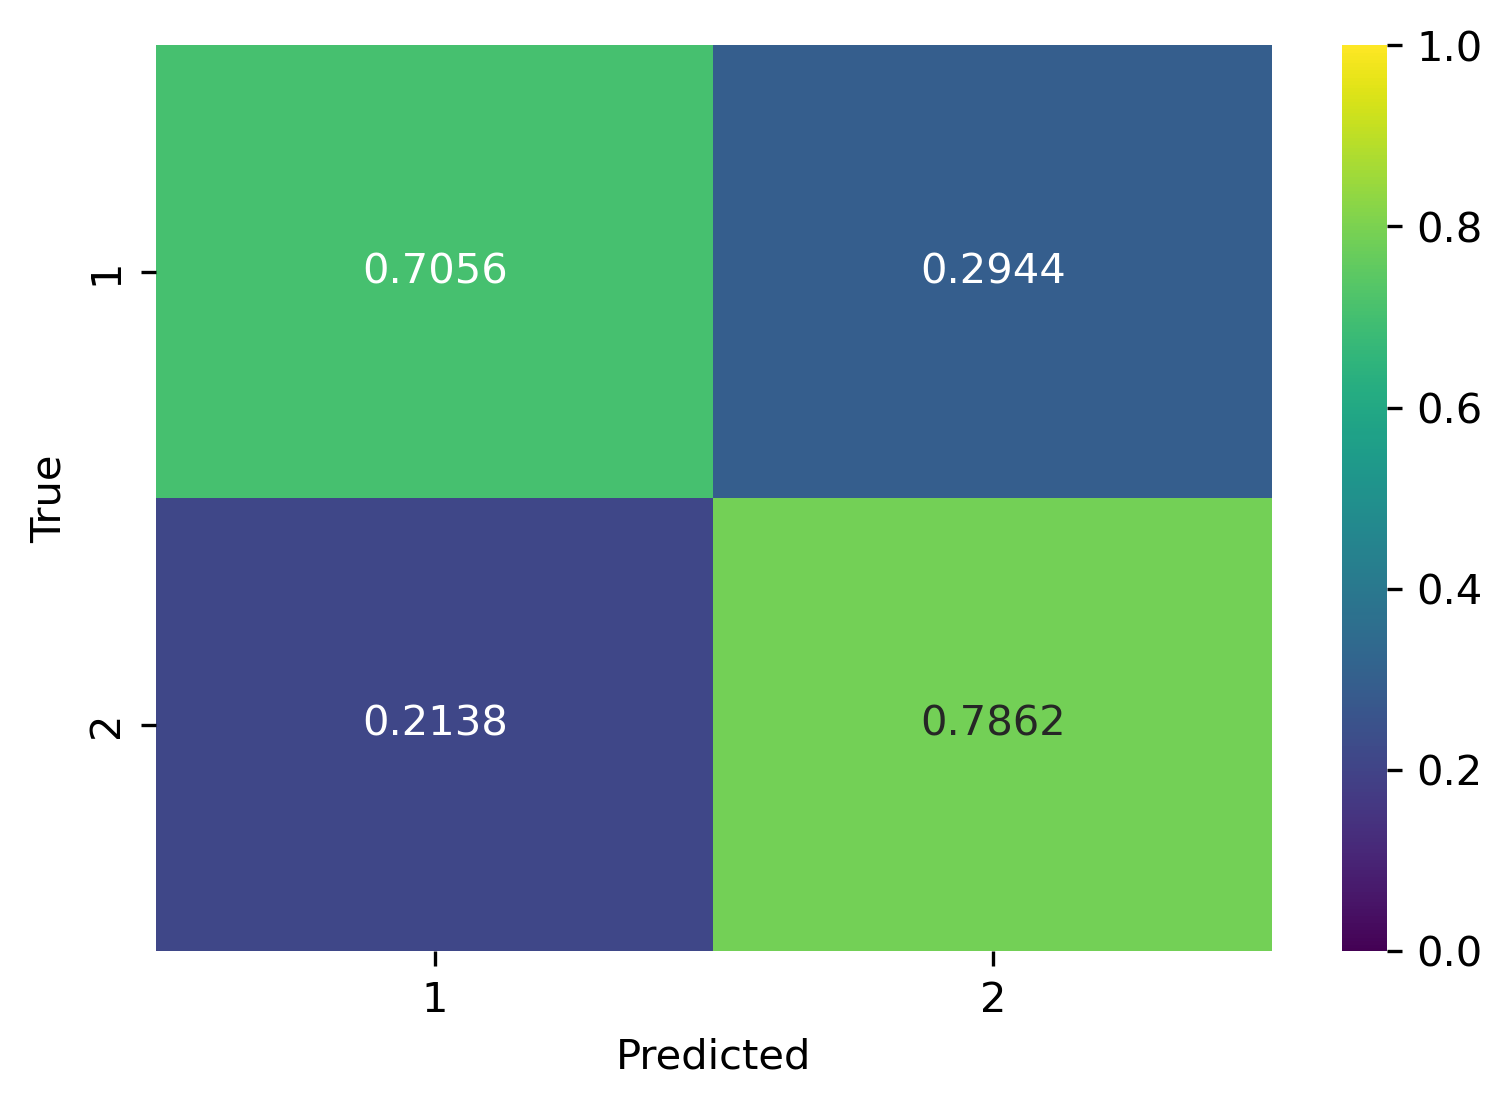

<IPython.core.display.Javascript object>

In [22]:
rus = RandomUnderSampler(random_state=1234)
sampled_chrometric_data, sampled_rep_labels = rus.fit_resample(chrometric_data, rep_labels)

fig, ax = plot_cv_conf_mtx(
    estimator=rfc,
    features=sampled_chrometric_data,
    labels=sampled_rep_labels,
    scale_features=True,
    n_folds=10,
    cmap="viridis",
    figsize=[6, 4],
    seed=1234,
)
plt.show()
plt.close()


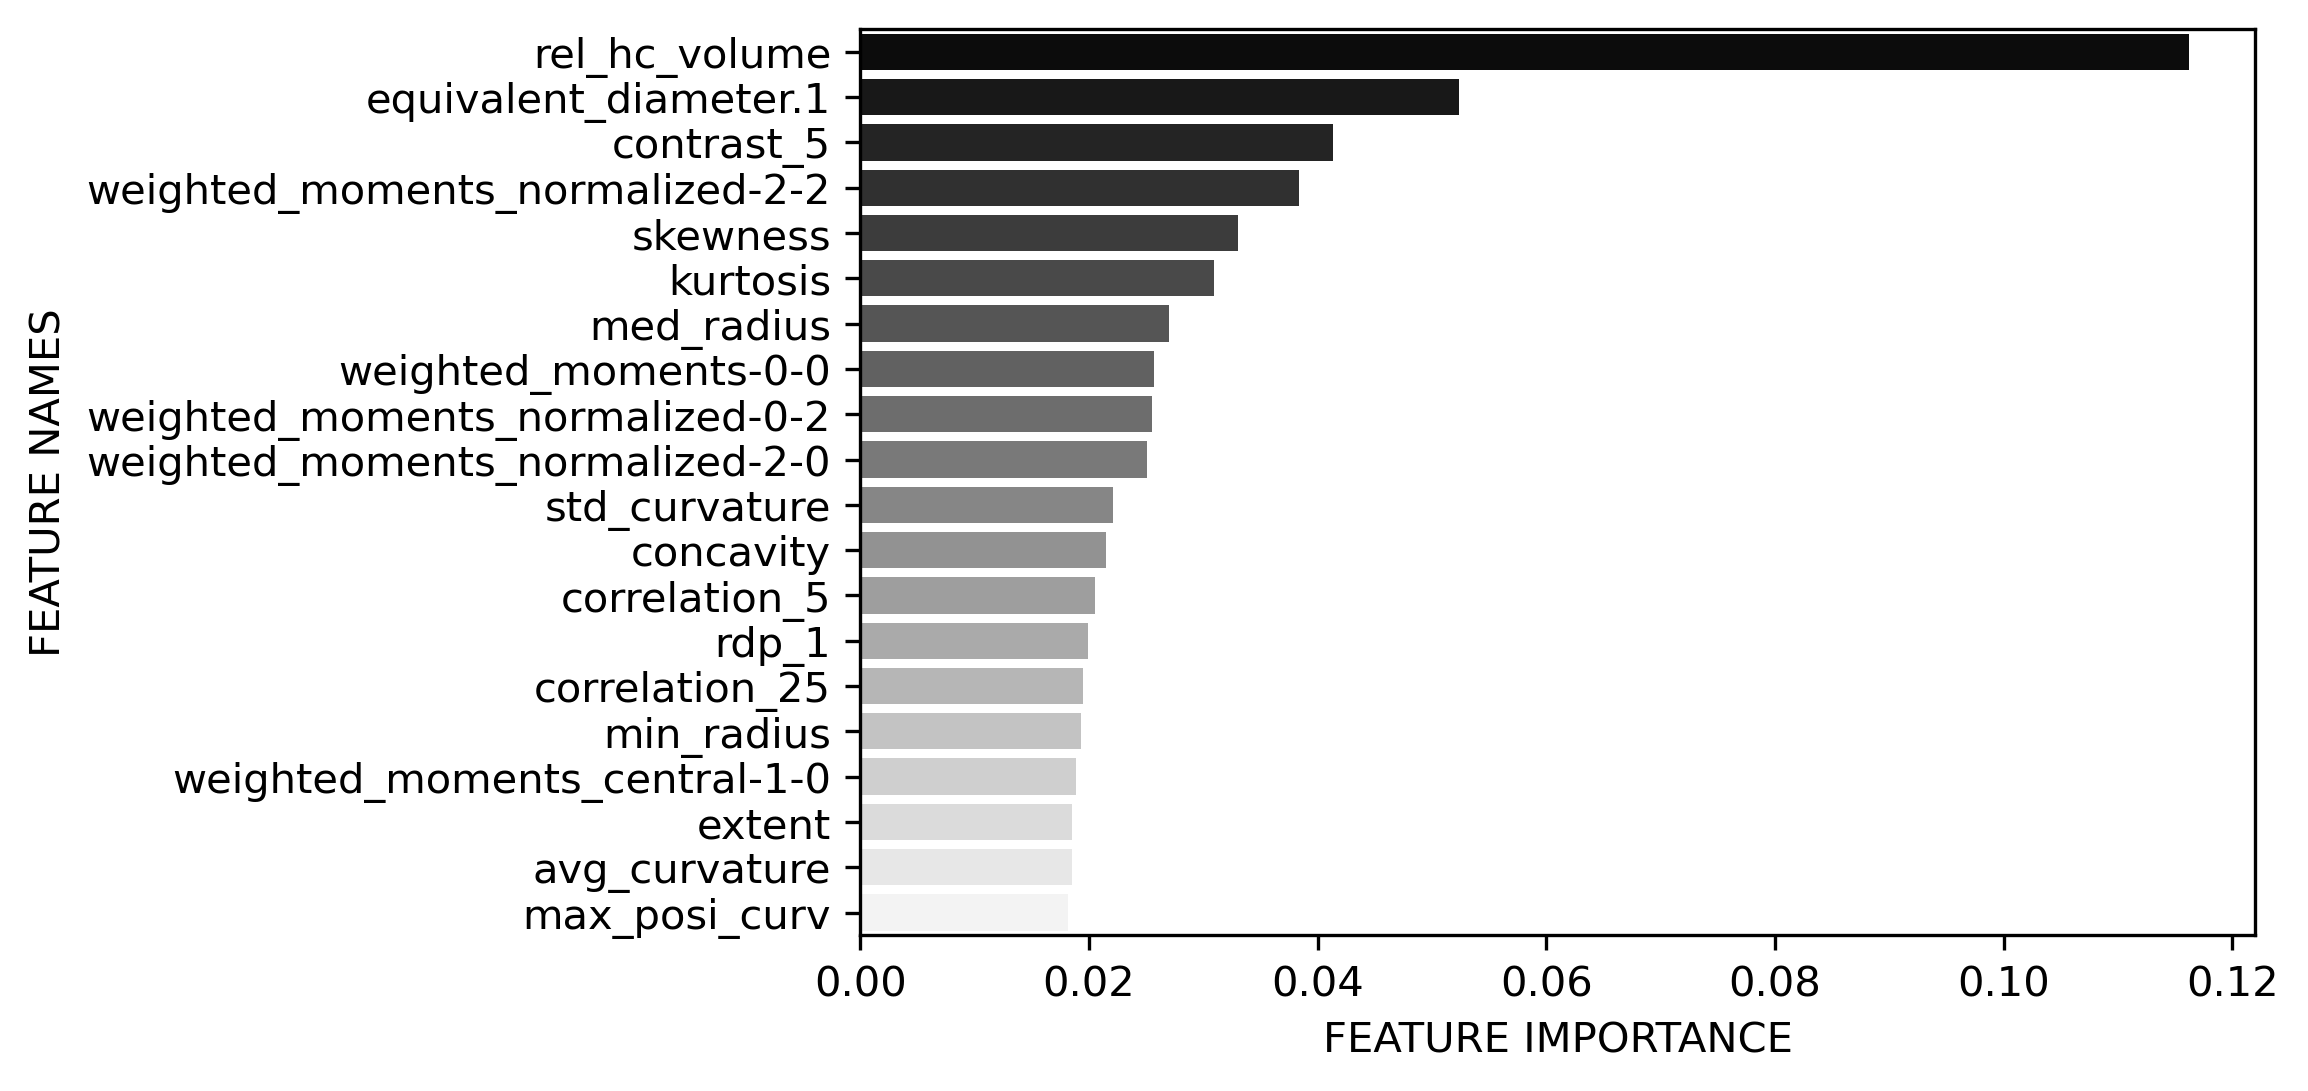

<IPython.core.display.Javascript object>

In [23]:
fig, ax = plot_feature_importance_for_estimator(
    rfc,
    sampled_chrometric_data,
    sampled_rep_labels,
    scale_features=True,
    cmap="gray",
    figsize=[6, 4],
)

---

### 3c. Patient-specific sample specificity

We will now check and see which patient samples contribute to the replicate specificity.

In [24]:
def get_patient_replicate_specificity(
    model, data, replicate_labels, sample_labels, n_folds=10, seed=1234
):
    samples = np.unique(sample_labels)
    rus = RandomUnderSampler(random_state=seed)
    result = {"sample": [], "balanced_accuracy": []}
    for sample in tqdm(samples, desc="Evaluate sample"):
        X, y = rus.fit_resample(
            data.loc[sample_labels == sample],
            replicate_labels[sample_labels == sample],
        )
        bacc = cross_val_score(model, X, y, cv=n_folds, scoring="balanced_accuracy")
        for i in range(n_folds):
            result["sample"].append(sample)
            result["balanced_accuracy"].append(bacc[i])
    result = pd.DataFrame(result)
    return result

<IPython.core.display.Javascript object>

In [25]:
sample_replicate_specificity_scores = get_patient_replicate_specificity(
    rfc, chrometric_data, rep_labels, sample_labels
)

Evaluate sample:   0%|          | 0/8 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Balanced accuracy')

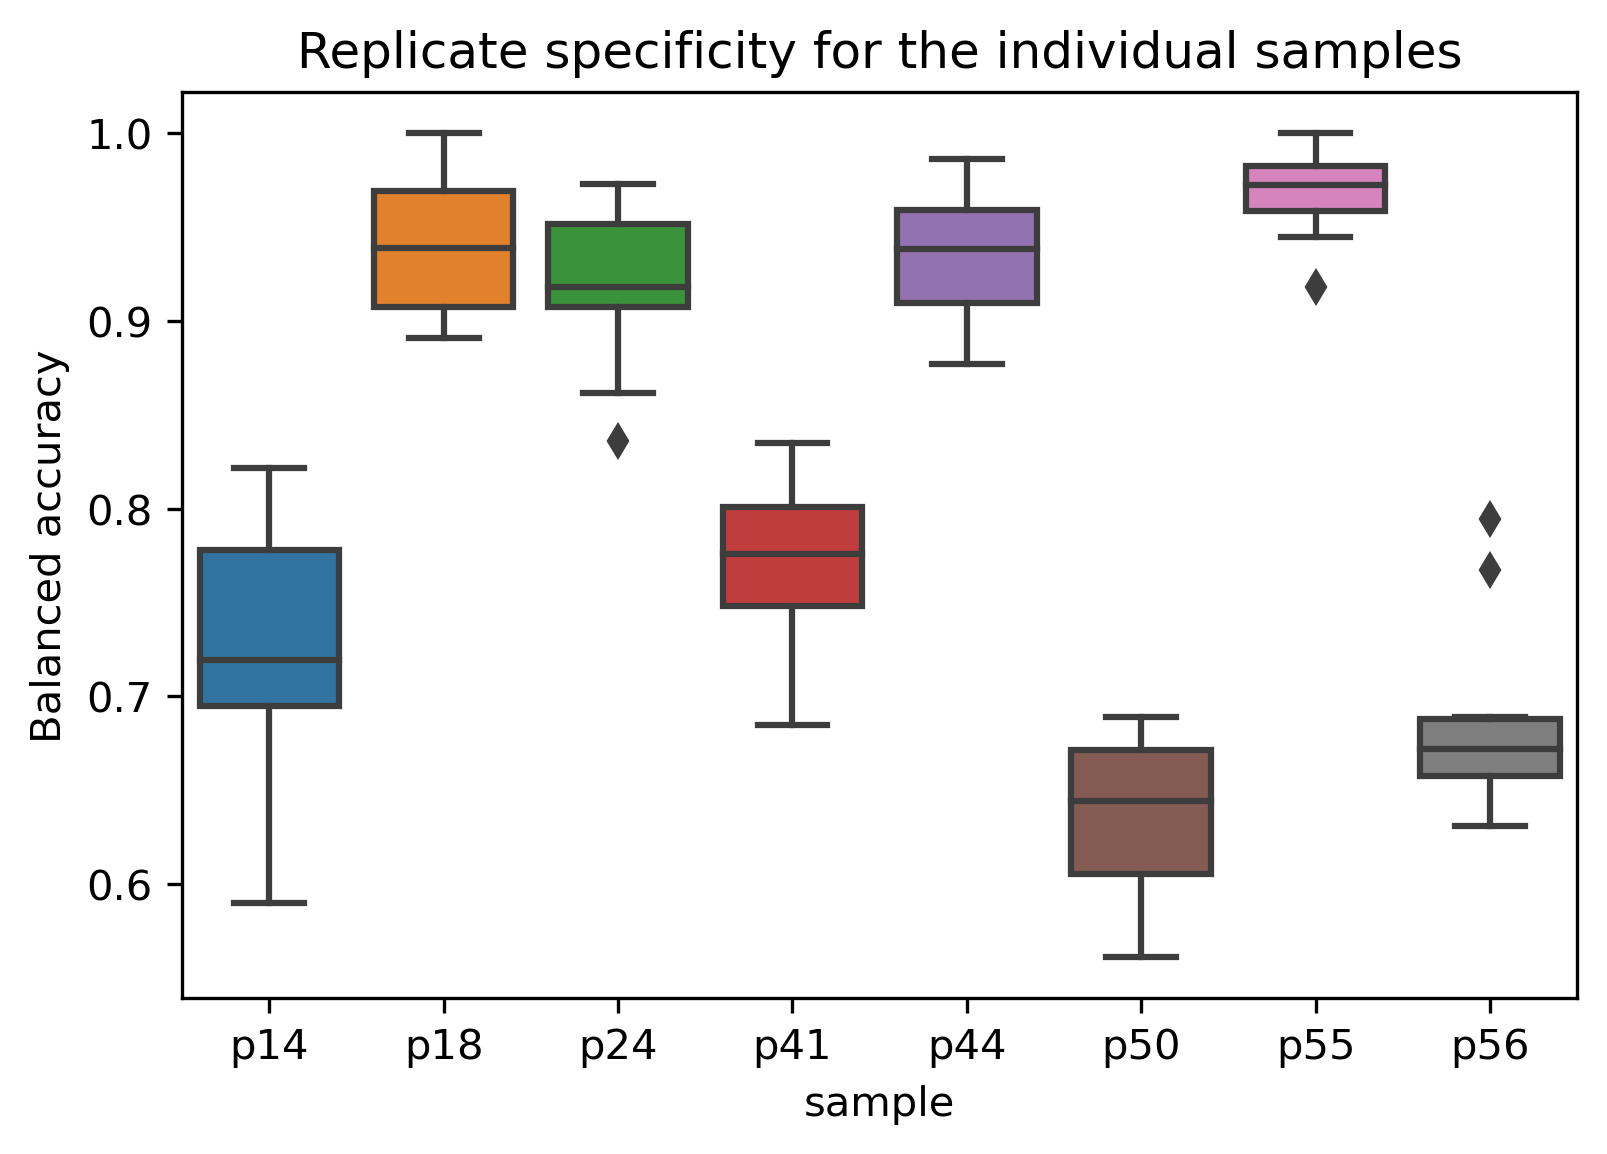

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.boxplot(
    data=sample_replicate_specificity_scores,
    x="sample",
    y="balanced_accuracy",
)
ax.set_title("Replicate specificity for the individual samples")
ax.set_ylabel("Balanced accuracy")